# Deciding parameter values for velocity and strain rate calculations

Updated Aug 8 by George Lu

Many of the notebooks in `strain_rates` addresses these decisions, but this notebook, like `deciding_profile_parameters` condenses and formalizes these decisions. For each station and season, it decides the noise floor location, coherence window size, and surface cutoff depth.

In [2]:
# Load libraries
import sys
import os
sys.path.append("../../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import pickle

import xarray as xr
import importlib
import pandas as pd
import math
from datetime import datetime, timedelta, date
from scipy.stats import linregress
from helpers import *

importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    19:33:50 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    19:33:50 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    19:33:50 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


## Deciding on noise floor location
This is a qualitative decision made by looking at the mean profile amplitude structure. It will be used to inform the coherence window size in addition to setting the area in which to fit the data.

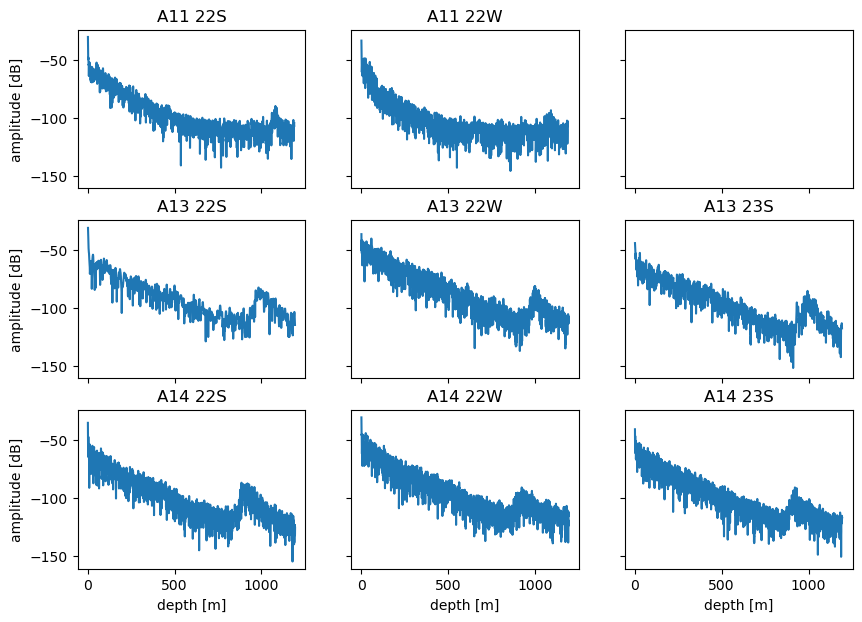

In [17]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, sharex=True,sharey=True,figsize = (10,7))
for i,station in zip(range(3),['A11','A13','A14']):
    for j,season in zip(range(3),['22S','22W','23S']):
        if i == 0 and j == 2:
            pass
        else:
            with open(f'{station}_{season}.pickle', 'rb') as handle:
                ds = pickle.load(handle)
            xa.dB(ds.mean(dim='time')).plot(ax=axs[i][j])
            axs[i][j].set_title(f'{station} {season}')
            if i == 2:
                axs[i][j].set_xlabel('depth [m]')
            else: 
                axs[i][j].set_xlabel('')

            if j == 0:
                axs[i][j].set_ylabel('amplitude [dB]')

We pick a generous cutoff for fitting that is applicable to all stations and seasons. We choose this to be 500 m. 

## Deciding on coherence window size
For coherence window size, we follow a general rule of thumb that we want at least 20 points to fit a line to for the estimation of vertical strain rates. This is because we are following the rule of thumb for 10 points for every free parameter, and after velocity normalization, only the slope of the linear fit is the free parameter. We then double this to account for any potential low coherence. We also assume that each step to the next bin is the same size as the bin itself. We can determine the maximum bin size with the following estimate:

$X = \frac{z_{floor}}{20\Delta z}$

This results in the following maximum coherence window sizes:



In [3]:
for i,station,noise_floor in zip(range(3),['A11','A13','A14'],[500,500,500]):
    for j,season in zip(range(3),['22S','22W','23S']):
        if i == 0 and j == 2:
            pass
        else:
            with open(f'{station}_{season}.pickle', 'rb') as handle:
                ds = pickle.load(handle)
            resolution = ds.profile_range.diff(dim='profile_range').mean().values
            max_bin = noise_floor/(20*resolution)
            print(f'Maximum bin size for {station} {season} (depth resolution of {float(resolution):.2f} m) is: {max_bin} points')
            

Maximum bin size for A11 22S (depth resolution of 0.42 m) is: 59.43590414892332 points
Maximum bin size for A11 22W (depth resolution of 0.21 m) is: 118.28333399934246 points
Maximum bin size for A13 22S (depth resolution of 0.84 m) is: 29.71497998204497 points
Maximum bin size for A13 22W (depth resolution of 0.26 m) is: 95.1010131491773 points
Maximum bin size for A13 23S (depth resolution of 0.42 m) is: 59.43590414892332 points
Maximum bin size for A14 22S (depth resolution of 0.23 m) is: 106.98938281592869 points
Maximum bin size for A14 22W (depth resolution of 0.21 m) is: 118.28333399934246 points
Maximum bin size for A14 23S (depth resolution of 0.26 m) is: 95.1010131491773 points


We round down to the nearest factors of 10 for cleaniless, and we will use a maximum bin size of 50, since we don't want to unneccessarily lower the depth resolution of our velocity estimates. We choose 50 because 50 times the station/season with the coarsest depth resolution that allows for 50+ points (A13 23S) is equivalent to the smallest bin size (20) times the largest depth resolution (0.84). This results in a bin size of 50 being used across all stations and seasons, with the exception of A13 22S, which will use 20.

In addition to the above parameter decisions, we also normalize velocity estimates by the mean velocity in the first two bins near the surface, as changes at the surface can result in apparent displacements throughout the ice column (see notebook `_`). 



For the lake drainage timeframe, we compare one burst after the next, since the event happens so quickly and has a large signal. However, as NOTEBOOK in `strain_rates` shows, doing this across seasons just results in noise that is not interprable. We therefore also decide on a larger time window across which we derive a single strain rate estimate. We opt to give daily strain rate estimates. We do so by _. 

!!!Make plots of near surface velocity errors. Also make plots of streaks and normalization